In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions

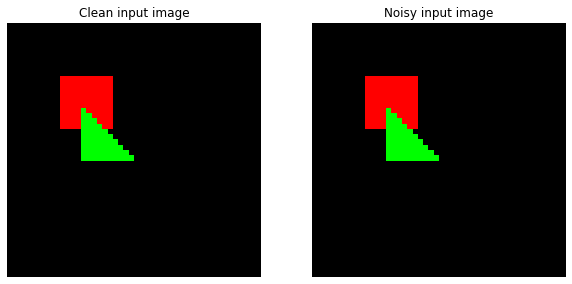

In [6]:
# Red square on black background

clean_img = np.zeros((48, 48, 3), dtype=np.float32)
L,H,_ = clean_img.shape

#make a square (Length height corner)

sL,sH = (10,10)
sCx,sCy = (10,10)
square = np.ones((sL,sH))
clean_img[sCx:sCx+sL, sCy:sCy+sL, 0] = clean_img[sCx:sCx+sL, sCy:sCy+sL, 0] + square


#make a triangle (length height corner)
tL,tH = (10,10)
tCx,tCy = (16,14)
# tCx,tCy = (26,24)
triangle = np.tril(np.ones((tL,tH)))
clean_img[tCx:tCx+tL, tCy:tCy+tL, 0] = np.maximum(0,clean_img[tCx:tCx+tL, tCy:tCy+tL, 0] - triangle)
clean_img[tCx:tCx+tL, tCy:tCy+tL, 1] = clean_img[tCx:tCx+tL, tCy:tCy+tL, 1] + triangle

# Add noise
img = clean_img + np.random.randn(*clean_img.shape)*0
mn, mx = img.min(), img.max()

# Adjust contrast (equally to both images)
img = (img - mn) / (mx - mn)
clean_img = (clean_img - mn) / (mx - mn)

plt.figure(figsize=[10, 10])
plt.subplot(121)
plt.imshow(clean_img)
plt.title('Clean input image')
plt.axis('off');
plt.subplot(122)
plt.imshow(img)
plt.title('Noisy input image')
plt.axis('off');

opts = SimpleNamespace()

opts.R                        = 21
opts.stride                   = 1
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.003
opts.lr_x0y0                  = 0.03
opts.lambda_boundary_final    = 0.5
opts.lambda_color_final       = 0.1
opts.nvals                    = 31
opts.num_initialization_iters = 30
opts.num_refinement_iters     = 1000
opts.greedy_step_every_iters  = 30
opts.parallel_mode            = True
opts.ang_per_vertex           = 2
foj = FieldOfJunctions(img, opts)


In [ ]:
import imageio

def foj_optimize_visualize_optimization():
    with imageio.get_writer('ColorTriSqOverlap2Ang.mp4', fps=60, quality=9) as writer:
        for i in range(foj.num_iters):
            if i == 0:
                print("Beginning initialization...")
            if i == opts.num_initialization_iters:
                print("Initialization done. Beginning refinement...")
            if i < opts.num_initialization_iters:
                if i % 1 == 0:
                    print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
            else:
                if i % 40 == 0:
                    print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
            foj.step(i)
            
            # Compute smoothed image and boundaries
            params = torch.cat([foj.angles, foj.x0y0], dim=1)
            dists, _, patches = foj.get_dists_and_patches(params)
            local_boundaries = foj.dists2boundaries(dists)
            global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()[:, :, np.newaxis].repeat(3,2)
            smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()
            output = np.concatenate([img, smoothed_img, global_boundaries], axis=1)
            
            writer.append_data(np.uint8(255.0 * output))


# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
%time foj_optimize_visualize_optimization()


Beginning initialization...
Initialization iteration 0/30
Initialization iteration 1/30
Initialization iteration 2/30
Initialization iteration 3/30
Initialization iteration 4/30
Initialization iteration 5/30
Initialization iteration 6/30
Initialization iteration 7/30
Initialization iteration 8/30
Initialization iteration 9/30
Initialization iteration 10/30
Initialization iteration 11/30
Initialization iteration 12/30
Initialization iteration 13/30
Initialization iteration 14/30
Initialization iteration 15/30
Initialization iteration 16/30
Initialization iteration 17/30
Initialization iteration 18/30
Initialization iteration 19/30
Initialization iteration 20/30
Initialization iteration 21/30
Initialization iteration 22/30
Initialization iteration 23/30
Initialization iteration 24/30
Initialization iteration 25/30
Initialization iteration 26/30
Initialization iteration 27/30
Initialization iteration 28/30
Initialization iteration 29/30
Initialization done. Beginning refinement...
Refinem

In [ ]:
from utils import patchstack
foj = FieldOfJunctions(img, opts)

patch_vis = patchstack(foj.img_patches)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(patch_vis)
plt.title('Input patches')
plt.axis('off');